In [2]:
import os 
import numpy as np 
import pandas as pd 
import scanpy as sc
import anndata
import copy
import desc
import matplotlib.pyplot as pl
# following line ensures the pl plots inline 
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

In [1]:
from importlib import reload
import utils.GE_functions as GE_functions
reload(GE_functions)

<module 'utils.GE_functions' from '/data/jlu/Chaperone_Analysis/notebooks/utils/GE_functions.py'>

The goal of this noteobok is to make a rank table of genes associated with Rtp1 / Rtp2 expression trajectory across the lineage of cells from GBC_INP_iOSN_mOSN. Additionally, this Olfr is NOT excluded from gene analysis but rather concatenated as a single Olfr gene in a none discriminatory manner. 
Output should be a datatable containing the different processed counts column with ranks of the genes relatively associated to Rtp1 / Rtp2 calculated by mean square error. 

#### Read in raw counts data 

In [ ]:
adata = anndata.read_csv('./files/Brann/GSE151346_MOE_all_counts.csv')
meta_data = pd.read_table('./files/Brann/GSE151346_MOE_metadata.tsv')
meta_data = meta_data.set_index('index')
# transpose used to flip obs and vars.
adata_brann = adata.copy().transpose()

In [ ]:
# Subset the adata by only cells included in metadata. Attach meta info onto adata
adata_brann = adata_brann[meta_data.index, :]
adata_brann.obs = adata_brann.obs.join(meta_data).dropna(axis = 0)

In [ ]:
# Plotting the provided UMAP coordinates on metafile to visualize 
fig = px.scatter(adata_brann.obs, x='UMAP_1', y= 'UMAP_2', color='leiden_name')
fig.update_traces(marker = dict(size = 3, opacity = 0.5))
fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    })
fig.show()

In [ ]:
# Subset the adata by interested cells. 
interested_cells = ['mOSN', 'iOSN', 'GBC', 'INP']
interested_cells_id = adata_brann.obs.leiden_name.isin(interested_cells)
adata_brann = adata_brann[interested_cells_id,:]

#### Pre-processing of data 
- From here only OSN lineage are kept in adata

In [ ]:
uOR_list = pd.read_csv('./files/Shayya/bk_rnaseq/uOR_Matsunami.csv')['id'].to_list()
oOR_list = pd.read_csv('./files/Shayya/bk_rnaseq/oOR_Matsunami.csv')['id'].to_list()
oOR_null_list = pd.read_csv('./output/oOR_nullexp.csv')['Olfr'].to_list()

In [ ]:
# convert anndata to pandas in order to manipulate count matrix 
pd_adata = pd.DataFrame(data=adata_brann.X, 
                        index=adata_brann.obs_names, 
                        columns=adata_brann.var_names)
# Concatenating all Olfr genes into a Olfr_sum as gene name
pd_Olfr = pd_adata[pd_adata.columns[pd_adata.columns.str.match('Olfr')]]
# Invert makes a new dataframe without any Olfr genes 
# pd_adata = pd_adata[pd_adata.columns[np.invert(pd_adata.columns.str.match('Olfr'))]]
pd_adata['Olfr_sum'] = pd_Olfr.sum(1)
pd_adata['uOR_sum'] = pd_Olfr[pd_Olfr.columns.intersection(uOR_list)].sum(1)
pd_adata['oOR_sum'] = pd_Olfr[pd_Olfr.columns.intersection(oOR_list)].sum(1)
pd_adata['oOR_null_sum'] = pd_Olfr[pd_Olfr.columns.intersection(oOR_null_list)].sum(1)
matrix = np.matrix(pd_adata)
# Reconstruct adata from pandas df 
obs = pd.DataFrame(index=pd_adata.index)
var = pd.DataFrame(index=pd_adata.columns)
adata_brann = anndata.AnnData(matrix, obs=obs, var=var)
# add meta data back again and save raw
adata_brann.obs = adata_brann.obs.join(meta_data).dropna(axis = 0)
adata_brann.raw = adata_brann

Now at this point, the anndata object we have only contains of GBC_INP_iOSN_mOSN, and additionally the Olfr genes have been concatenated. Now simply continue to perpare for pseudotime analysis

In [ ]:
# normalize to depth 10 000
sc.pp.normalize_per_cell(adata_brann, counts_per_cell_after=1e4)
# logaritmize
sc.pp.log1p(adata_brann)

In [ ]:
adata_brann.var['mt'] = adata_brann.var_names.str.startswith('Mt') 
sc.pp.calculate_qc_metrics(adata_brann, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [ ]:
# Define genes to be removed from the datasets prior to finding highly variable genes for clustering
mito_genes = adata_brann.var_names.str.startswith('mt-')
malat1 = adata_brann.var_names.str.startswith('Malat')

# Adds the True positions together for a remove list 
remove = np.add(mito_genes, malat1)
keep = np.invert(remove)

adata_brann = adata_brann[:,keep]
print(adata_brann.n_obs, adata_brann.n_vars)

In [ ]:
sc.tl.pca(adata_brann, svd_solver='arpack')
sc.pp.neighbors(adata_brann, n_neighbors=10, n_pcs=40)
sc.tl.draw_graph(adata_brann)
sc.tl.umap(adata_brann)

In [ ]:
sc.set_figure_params(facecolor='white')
sc.pl.umap(adata_brann, color=['Omp', 'Rtp1','Olfr_sum','leiden_name'], size=20)

In [ ]:
sc.pl.umap(adata_brann, color=['Olfr_sum', 'uOR_sum', 'oOR_sum', 'oOR_null_sum'], size=20)

In [ ]:
# Clustering PAGA via leiden clustering method
sc.tl.leiden(adata_brann, resolution = 0.5)
sc.tl.paga(adata_brann, groups='leiden')

In [ ]:
sc.pl.draw_graph(adata_brann, color=['leiden'], legend_loc='on data')

In [ ]:
sc.pl.paga(adata_brann, color=['Omp'])

In [ ]:
sc.tl.draw_graph(adata_brann, init_pos='umap')
sc.pl.draw_graph(adata_brann, color=['leiden', 'leiden_name'], legend_loc='on data', size=20)

In [ ]:
# Save data with the raw counts
adata = adata_brann.raw.to_adata()
adata.write('./files/Brann/GSE151346_MOE_ALL_Olfr.h5ad') 

In [3]:
adata = desc.read_h5ad('../files/Brann/GSE151346_MOE_ALL_Olfr.h5ad')

In [4]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata, resolution = 1)
sc.tl.paga(adata, groups='leiden')

In [5]:
# Store raw counts in adata.raw so we don't lose the values when processing 
adata.raw = adata
adata_log1p = adata.copy()

In [6]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.normalize_total(adata_log1p, target_sum=1e4)
sc.pp.log1p(adata_log1p)

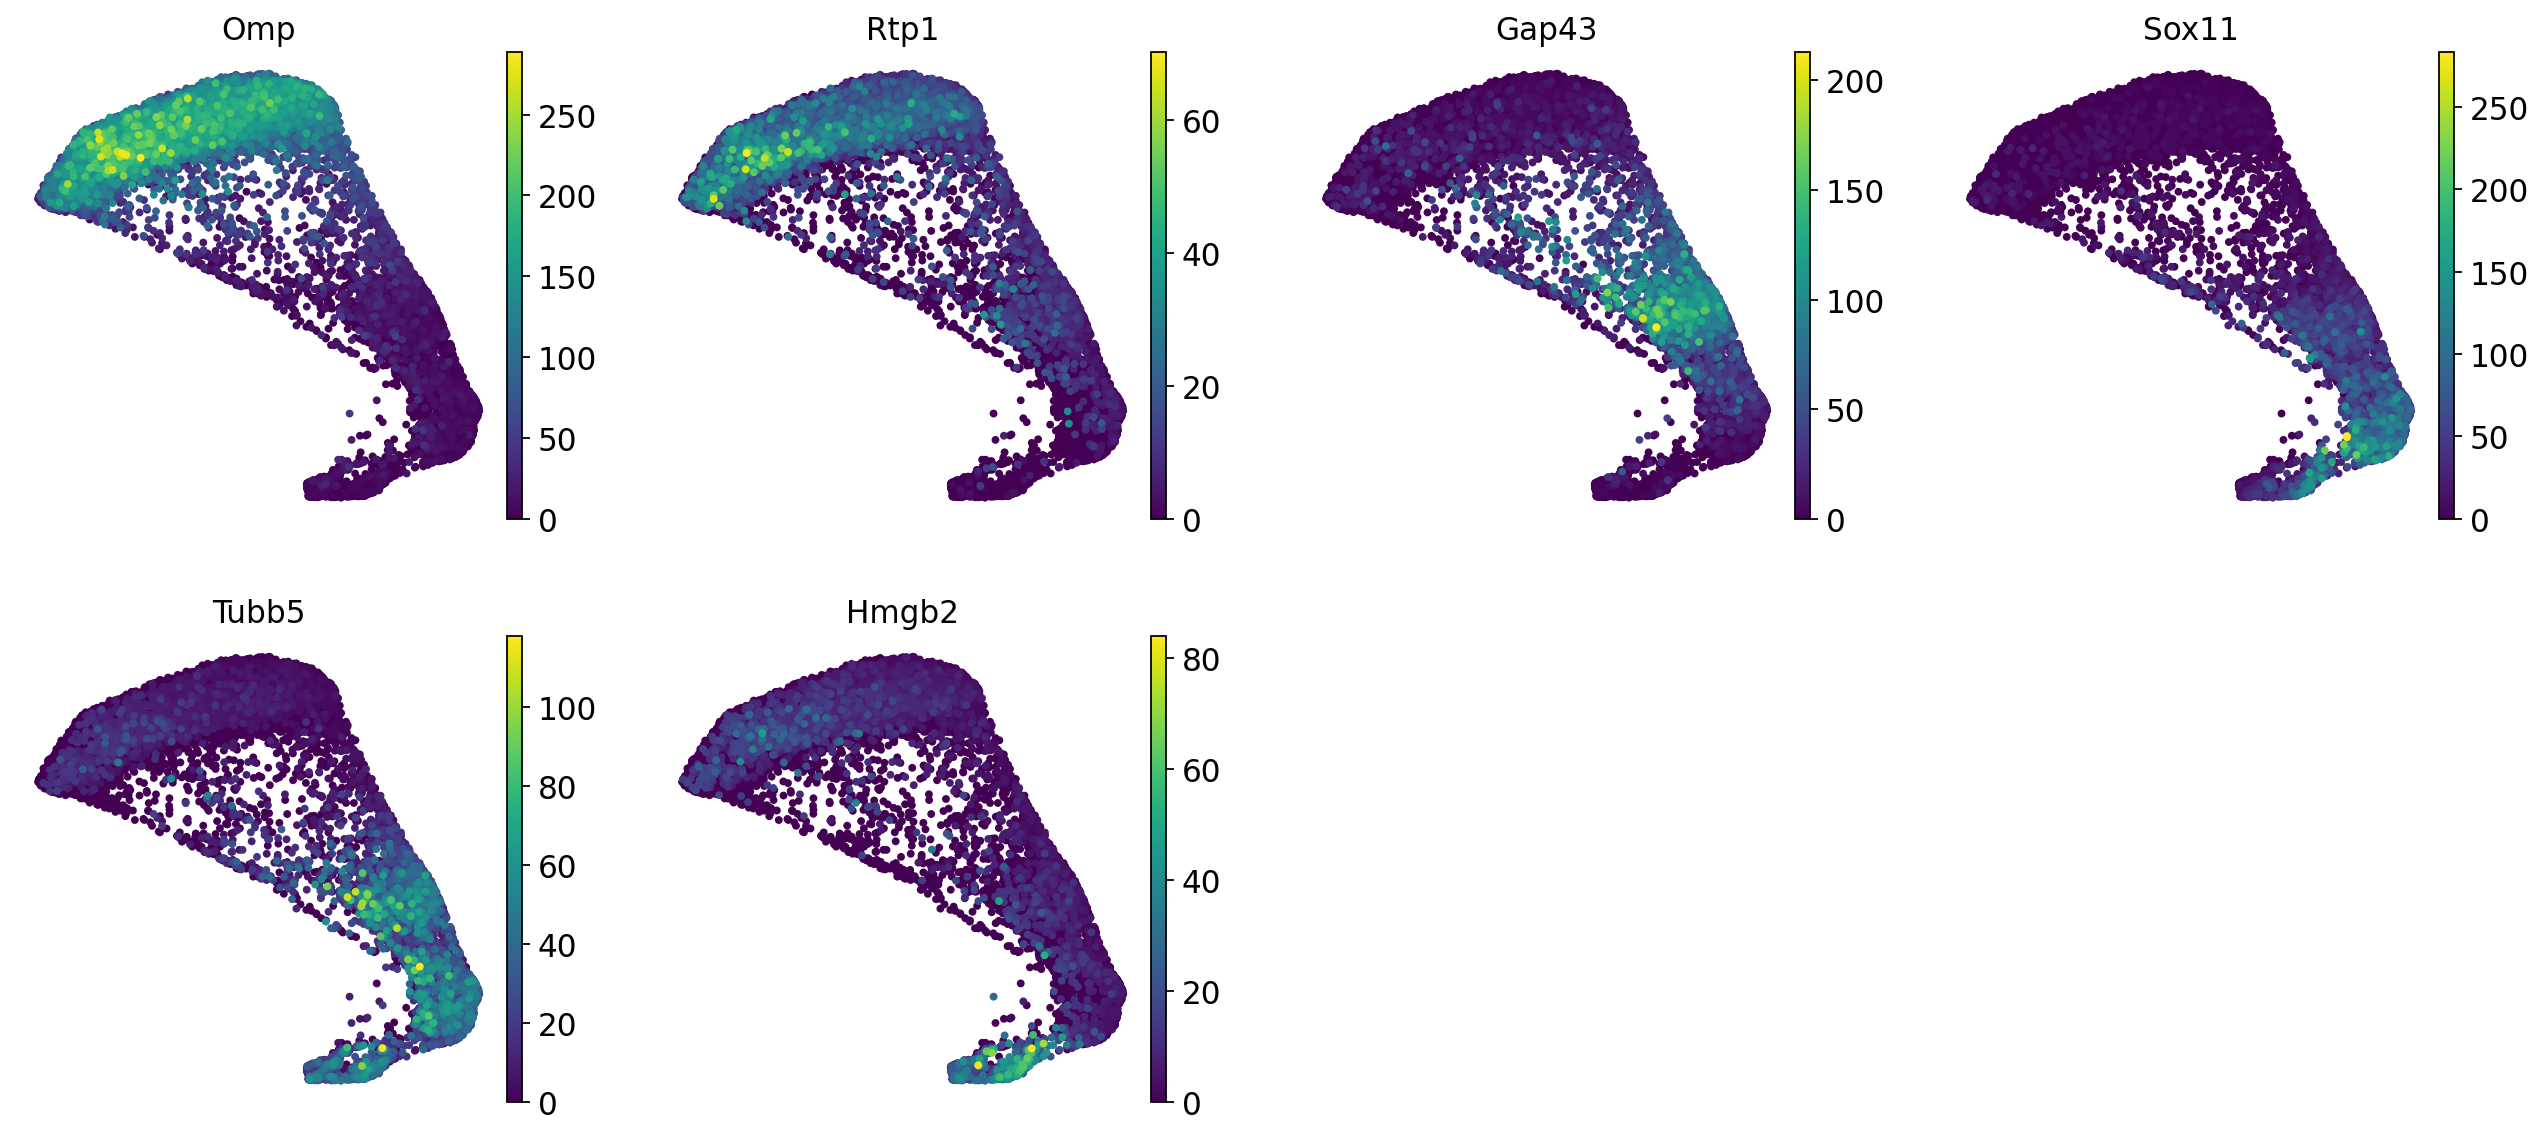

In [7]:
sc.set_figure_params(facecolor='white')
sc.pl.draw_graph(adata, color=['Omp','Rtp1', 'Gap43', 'Sox11', 'Tubb5', 'Hmgb2'], 
                 size=50, use_raw=False, 
                 frameon=False)

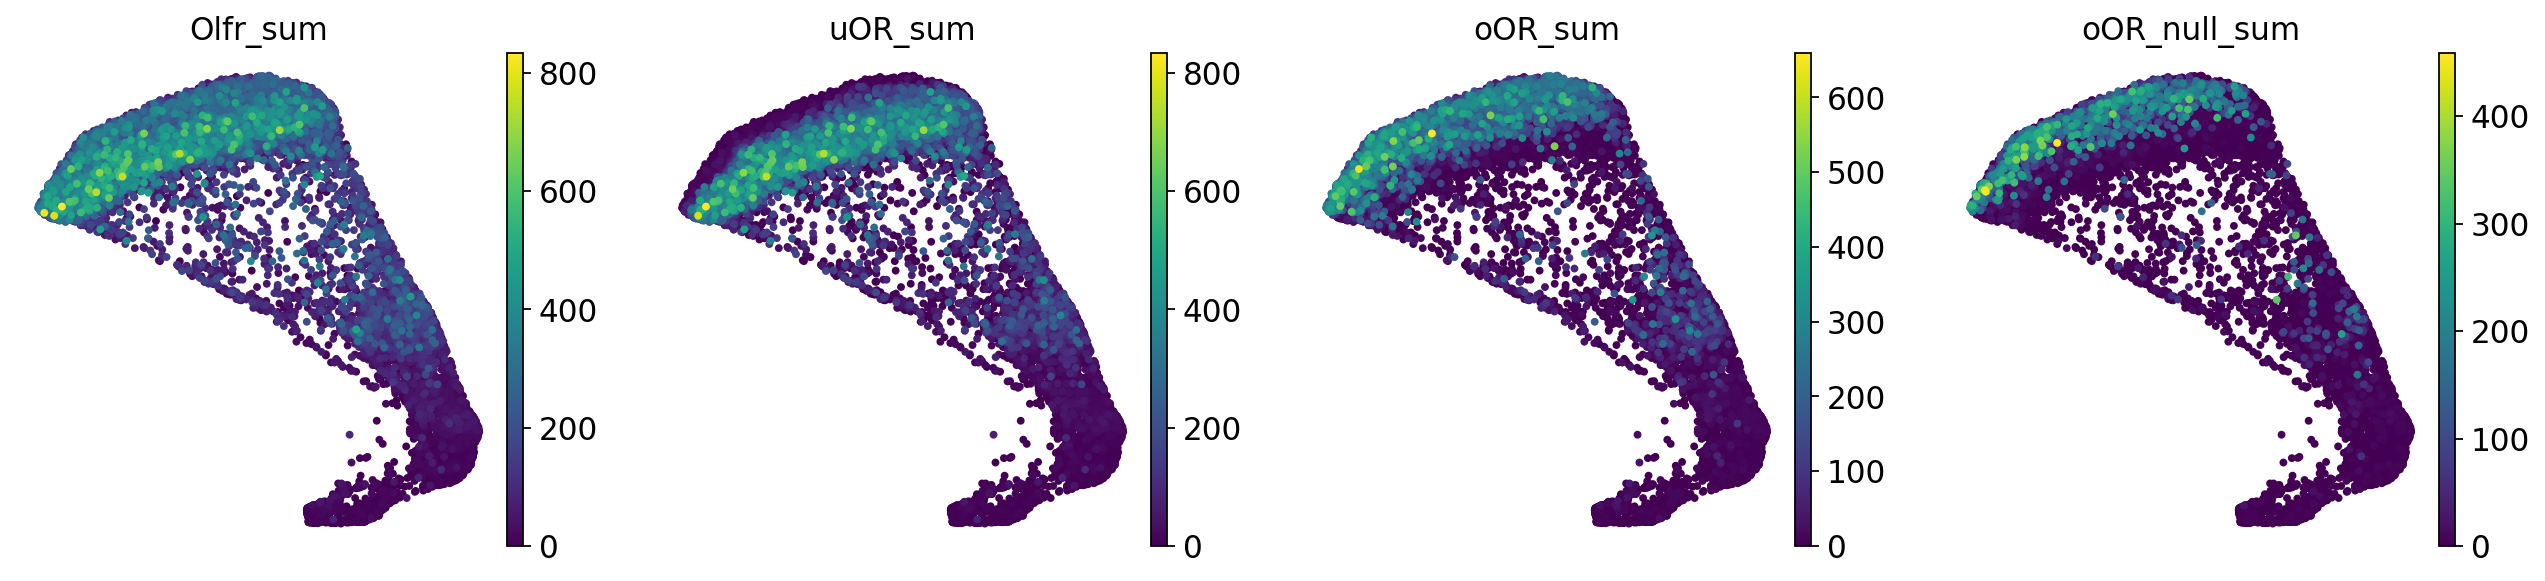

In [ ]:
sc.set_figure_params(facecolor='white')
sc.pl.draw_graph(adata, color=['Olfr_sum','uOR_sum', 'oOR_sum','oOR_null_sum'], legend_loc='on data', 
                 size=50, use_raw=False, 
                 frameon=False)

In [ ]:
sc.set_figure_params(facecolor='white')
sc.pl.draw_graph(adata_log1p, color=['Omp','Rtp1', 'Sox11', 'Gap43'], 
                 size=50, use_raw=False, 
                 frameon=False)

In [ ]:
sc.set_figure_params(facecolor='white')
sc.pl.draw_graph(adata_log1p, color=['Olfr_sum','uOR_sum', 'oOR_sum', 'oOR_null_sum'], legend_loc='on data', size=50, use_raw=False)

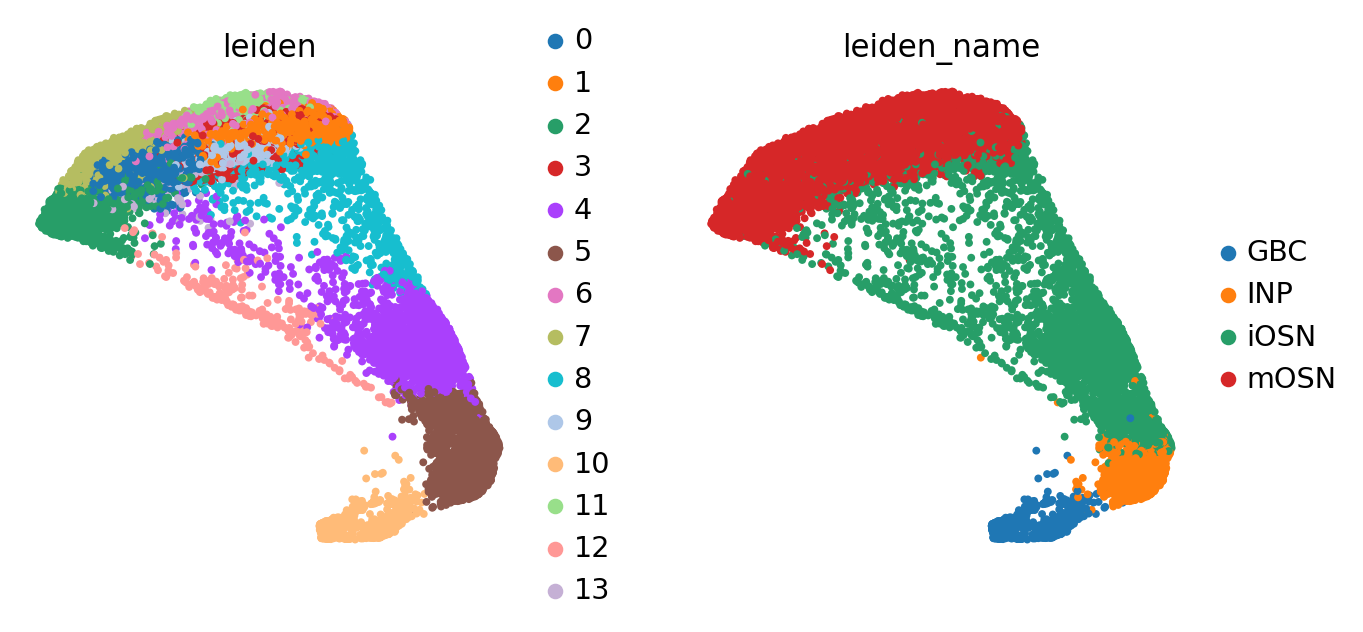

In [ ]:
sc.set_figure_params(facecolor='white')
sc.pl.draw_graph(adata, color=['leiden','leiden_name', ], 
                #  legend_loc='on data', 
                 size=50, 
                 frameon=False)

In [ ]:
sc.set_figure_params(facecolor='white')
sc.pl.draw_graph(adata_log1p, color=['leiden','leiden_name'], legend_loc='on data', size=50)

In [ ]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['leiden']  == '10')[0]
sc.tl.dpt(adata)
adata_log1p.uns['iroot'] = np.flatnonzero(adata_log1p.obs['leiden']  == '10')[0]
sc.tl.dpt(adata_log1p)

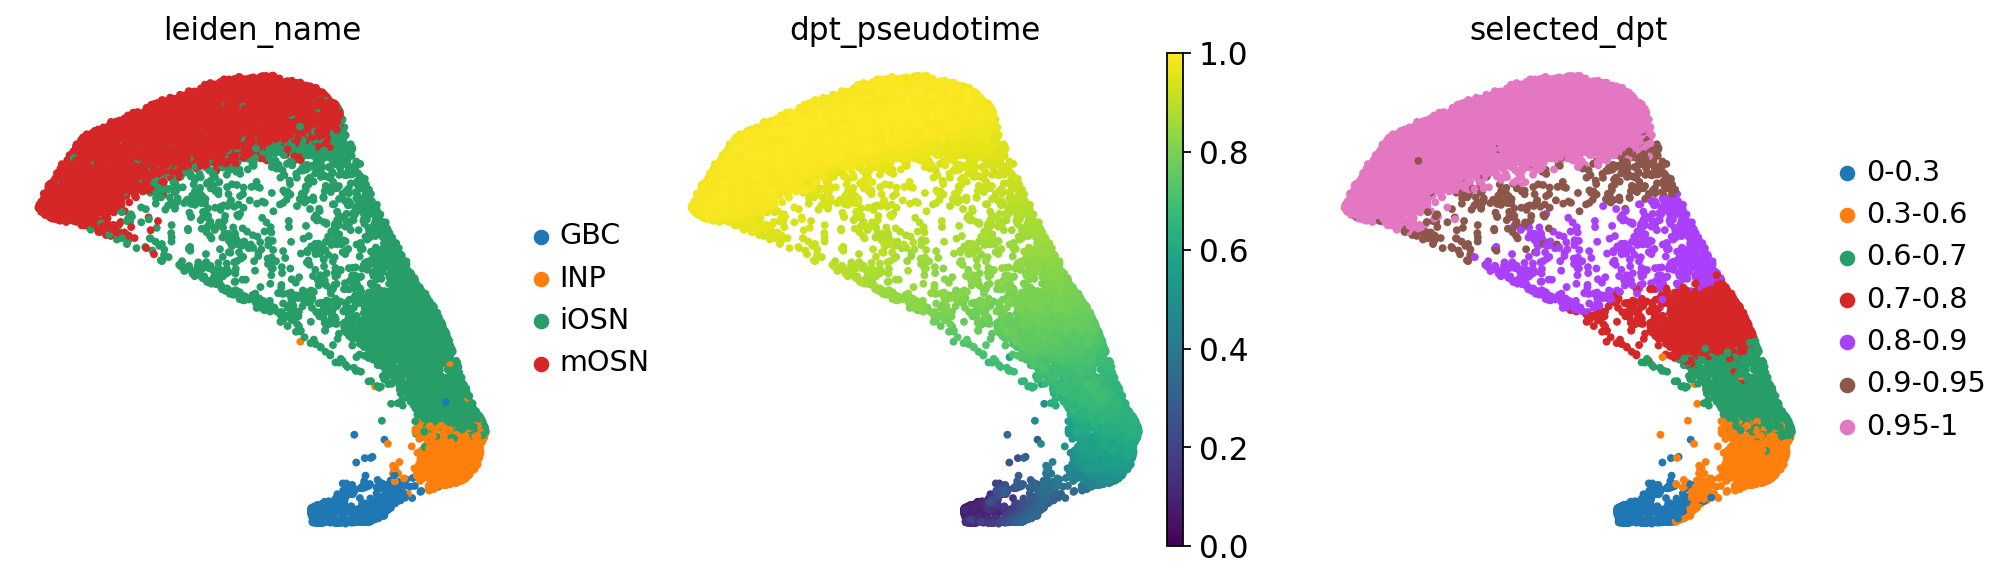

In [ ]:
sc.pl.draw_graph(adata, color=['leiden_name', 'dpt_pseudotime', 'selected_dpt'], 
                #  legend_loc='on data', 
                 size=50, frameon=False)

In [ ]:
adata = GE_functions.add_selected_dpt(adata, dpt_cutoff=[0,0.3,0.6,0.7,0.8,0.9,0.95,1])
sc.pl.draw_graph(adata, color=['selected_dpt'], legend_loc='on data', size=50)

In [ ]:
adata_log1p = GE_functions.add_selected_dpt(adata_log1p, dpt_cutoff=[0,0.3,0.6,0.7,0.8,0.9,0.95,1])
sc.pl.draw_graph(adata_log1p, color=['selected_dpt'], legend_loc='on data', size=50)

In [ ]:
# Saving normalized adata. Raw contains untouched raw counts. 
adata.write('../files/Brann/GSE151346_MOE_ALL_Olfr.h5ad') 
adata_log1p.write('../files/Brann/GSE151346_MOE_ALL_Olfr_log1p.h5ad') 

#### Generating gene expression table

In [ ]:
adata = sc.read_h5ad('../files/Brann/GSE151346_MOE_ALL_Olfr.h5ad')
adata_log1p = sc.read_h5ad('../files/Brann/GSE151346_MOE_ALL_Olfr_log1p.h5ad')

In [ ]:
gene_names = GE_functions.get_gene_names(adata)
# gene_names.append('Olfr_sum')
gene_names.append('uOR_sum')
gene_names.append('oOR_sum')
gene_names.append('oOR_null_sum')

In [ ]:
# construct ge_table FOR BOTH log1p and normalized data. (You don't need both)
ge_normalized = GE_functions.get_ge_table(adata, gene_names, ge_across='selected_dpt')
ge_log1p = GE_functions.get_ge_table(adata_log1p, gene_names, ge_across='selected_dpt')
# convert average gene expression to relative gene expression. (Optional )
ge_normalized_normExp = GE_functions.gene_to_relative_expression(ge_normalized.copy())
ge_log1p_normExp = GE_functions.gene_to_relative_expression(ge_log1p.copy())

In [ ]:
# Construct mse_table from the ge_table values relative to Rtp1(Default)
mse_normalized_rtp1 = GE_functions.get_mse_table(ge_normalized, gene_names)
mse_log1p_rtp1 = GE_functions.get_mse_table(ge_log1p, gene_names)
mse_normalized_normExp_rtp1 = GE_functions.get_mse_table(ge_normalized_normExp, gene_names)
mse_log1p_normExp_rtp1 = GE_functions.get_mse_table(ge_log1p_normExp, gene_names)

mse_table constructed
mse_table constructed
mse_table constructed
mse_table constructed


In [ ]:
# ge_normalized.to_csv('./expression_csv/ge_normalized_GSE151346_MOE_ALL_OlfrSum.csv')
# mse_normalized_rtp1.to_csv('./expression_csv/mse_normalized_rtp1_GSE151346_MOE_ALL_OlfrSum.csv')
# ge_log1p.to_csv('./expression_csv/ge_log1p_GSE151346_MOE_ALL_OlfrSum.csv')
# mse_log1p_rtp1.to_csv('./expression_csv/mse_log1p_rtp1_rtp1_GSE151346_MOE_ALL_OlfrSum.csv')

In [ ]:
mse_combined = mse_normalized_rtp1.transpose().rename(columns = {'mse': 'mse_normalized_rtp1'}).join(
               mse_log1p_rtp1.transpose().rename(columns = {'mse': 'mse_log1p_rtp1'})).join(
               mse_normalized_normExp_rtp1.transpose().rename(columns = {'mse': 'mse_log1p_normExp_rtp1'})).join(
               mse_log1p_normExp_rtp1.transpose().rename(columns = {'mse': 'mse_log1p_normExp_rtp1'})
               )

In [ ]:
# combining normalized and processed mse_table and save 
mse_combined = mse_normalized_rtp1.transpose().rename(columns = {'mse': 'mse_normalized_rtp1'}).join(
               mse_log1p_rtp1.transpose().rename(columns = {'mse': 'mse_log1p_rtp1'})).join(
               mse_normalized_normExp_rtp1.transpose().rename(columns = {'mse': 'mse_log1p_normExp_rtp1'})).join(
               mse_log1p_normExp_rtp1.transpose().rename(columns = {'mse': 'mse_log1p_normExp_rtp1'})
               )
mse_combined.to_csv('../output/brann/mse_combined_rtp1.csv')

# Convert to ranks and save
ranked_df = mse_combined.rank(method='min', ascending=False).astype(int)
ranked_df.to_csv('../output/brann/Rank_mse_combined_rtp1.csv')

In [ ]:
# To construct a reverse rank order. For investigating reverse correlated genes. 
# Since there is more nuisance in finding negative correlated genes. Here we have some criteria to filter 
# The start expression needs to be higher than end expression. 
# In normExp, the max expression before normExp should be > 0.1. 

# construct ge_table FOR BOTH log1p and normalized data. (You don't need both)
# filtering for genes that are increasing in expression. 
ge_normalized_col = ge_normalized.loc[:, ge_normalized.iloc[0] > ge_normalized.iloc[-1]].columns
ge_log1p_col = ge_log1p.loc[:, ge_log1p.iloc[0] > ge_log1p.iloc[-1]].columns
# filgtering for genes that have extremely low max expression 
ge_normalized_col = ge_normalized.loc[:,ge_normalized.columns.isin(ge_normalized_col)].loc[:, ge_normalized.loc[:,ge_normalized.columns.isin(ge_normalized_col)].max() > 0.1].columns
ge_log1p_col = ge_log1p.loc[:,ge_log1p.columns.isin(ge_log1p_col)].loc[:,ge_log1p.loc[:,ge_log1p.columns.isin(ge_log1p_col)].max() > 0.1].columns

# Assigning Rtp1 and index back as they are probably dropped 
ge_normalized_col = ge_normalized_col.insert(0, 'index')
ge_normalized_col = ge_normalized_col.insert(1, 'Rtp1')
ge_log1p_col = ge_log1p_col.insert(0, 'index')
ge_log1p_col = ge_log1p_col.insert(1, 'Rtp1')

# Construct mse_table from the ge_table values relative to Rtp1(Default)
mse_normalized_rtp1 = mse_normalized_rtp1.loc[:,mse_normalized_rtp1.columns.isin(ge_normalized_col)]
mse_log1p_rtp1 = mse_log1p_rtp1.loc[:,mse_log1p_rtp1.columns.isin(ge_log1p_col)]
mse_normalized_normExp_rtp1 = mse_normalized_normExp_rtp1.loc[:,mse_normalized_normExp_rtp1.columns.isin(ge_normalized_col)]
mse_log1p_normExp_rtp1 = mse_log1p_normExp_rtp1.loc[:,mse_log1p_normExp_rtp1.columns.isin(ge_log1p_col)]

# combining normalized and processed mse_table and save 
mse_combined = mse_normalized_rtp1.transpose().rename(columns = {'mse': 'mse_normalized_rtp1'}).join(
               mse_log1p_rtp1.transpose().rename(columns = {'mse': 'mse_log1p_rtp1'})).join(
               mse_normalized_normExp_rtp1.transpose().rename(columns = {'mse': 'mse_normalized_normExp_rtp1'})).join(
               mse_log1p_normExp_rtp1.transpose().rename(columns = {'mse': 'mse_log1p_normExp_rtp1'})
               )

# Read in and filter for genes that IS expressed in Hek cells
hek_df = pd.read_csv('../files/Hek293_rnaseq/GSE122425_all.counts.293.csv')
hek_expressed_genes = hek_df[hek_df.rpkm_mean > 1].GeneSymbol.to_list()
# Filter the mse gene list by only genes that are expressed in Hek293 cells. Make exception for Rtp1. 
mse_combined = mse_combined[(mse_combined.index.str.upper().isin(hek_expressed_genes)) |
                            (mse_combined.index == 'Rtp1')].sort_values('mse_normalized_normExp_rtp1')


# Convert to ranks and save
ranked_df = mse_combined.rank(method='min', ascending=False)

import re
ranked_df = ranked_df.loc[[gene for gene in ranked_df.index if not re.compile(r'Gm\d{5}\b').match(gene)], : ]
ranked_df = ranked_df[~ranked_df.index.str.endswith('Rik')]

import mygene
mg = mygene.MyGeneInfo()
gene_symbols = ranked_df.index.tolist()
gene_info = mg.querymany(gene_symbols, scopes='symbol', fields='name', species='mouse')
gene_info_df = pd.DataFrame(gene_info)

ranked_df = pd.merge(ranked_df, gene_info_df[['query', 'name']], left_index=True, right_on='query', how='left').set_index('query')
ranked_df.to_csv('../output/brann/Rank-Reverse-filtered_mse_combined_rtp1.csv')


querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-4927...done.
Finished.
10 input query terms found dup hits:
	[('Hyi', 2), ('Snhg9', 2), ('Thap6', 2), ('Snhg15', 2), ('Tug1', 2), ('Snhg6', 2), ('Snord104', 2), 
121 input query terms found no hit:
	['Tmem56', 'Nupl2', 'Fam173b', 'Mkl2', 'Trove2', 'Pycrl', 'Fam102a', 'Pqlc1', 'Fam206a', 'Atp5b', 'C
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [ ]:
# # calculate mse_table relative to rtp2
# mse_normalized_rtp2 = GE_functions.get_mse_table(ge_normalized, gene_names, mse_gene='Rtp2')
# mse_log1p_rtp2 = GE_functions.get_mse_table(ge_log1p, gene_names, mse_gene='Rtp2')
# # combining normalized and processed mse_table and save 
# mse_combined = mse_normalized_rtp2.transpose().rename(columns = {'mse': 'mse_normalized_normExp_ALL_Olfr_rtp2'}).join(
#     mse_log1p_rtp2.transpose().rename(columns = {'mse': 'mse_log1p_normExp_ALL_Olfr_rtp2'}))
# # mse_combined.to_csv('./output/brann/mse_combined_ALL_Olfr_rtp2.csv')
# mse_combined.to_csv('./output/brann/mse_combined_normExp_ALL_Olfr_rtp2.csv')

In [ ]:
gene_names = list(mse_combined.index)
excluded_genes = GE_functions.get_excluded_genes(gene_names)
excluded_genes.append('Olfr_sum')

In [ ]:

# mse_combined_rtp2 = pd.read_csv('./output/brann/mse_combined_normExp_ALL_Olfr_rtp2.csv', index_col=[0])
# rank_combined_rtp2 = GE_functions.mse_to_rank(mse_combined_rtp2, col_names=['mse_rank_normalized_normExp_ALL_Olfr_rtp2',
#                                                  'mse_rank_log1p_normExp_ALL_Olfr_rtp2'])
# # For reindexing if ever need to match index to master list 
# index_order = pd.read_csv('./output/brann/Rank_gene_combined_ALL_Olfr_rtp1.csv', index_col=[0]).index
# rank_combined_rtp2.reindex(index_order).to_csv('./output/brann/Rank_gene_combined_normExp_ALL_Olfr_rtp2.csv')

##### Sub-goal
To find Calnexin, Calreticulin gene family that is expressed in hek cells

In [ ]:
hek_df = pd.read_csv('../files/Hek293_rnaseq/GSE122425_all.counts.293.csv')
hek_expressed_genes = hek_df[hek_df.rpkm_mean > 1].GeneSymbol.to_list()

In [ ]:
hek_df[hek_df.GeneSymbol.str.contains('Canx|Calr|Clgn', case=False)]

,gene_id,length,HEK293-SEQ1,HEK293-SEQ2,HEK293-SEQ3,HEK293-SEQ1_RPKM,HEK293-SEQ2_RPKM,HEK293-SEQ3_RPKM,counts_mean,counts_std,rpkm_mean,rpkm_std,GeneSymbol,KO,GO
1570,ENSG00000227742,33032,4,1,3,0.11,0.03,0.08,2.666667,1.527525,0.073333,0.040415,CALR4P,K08057,_
26287,ENSG00000179218,5912,54770,54968,61443,301.90,300.36,306.26,57060.333330,3796.791584,302.840000,3.060261,CALR,K08057,biological_process:negative regulation of tran...
26448,ENSG00000269058,17136,0,6,6,0.00,0.08,0.07,4.000000,3.464102,0.050000,0.043589,CALR3,K10098,molecular_function:calcium ion binding(GO:0005...
40835,ENSG00000153132,39514,166,196,195,0.98,1.14,1.04,185.666667,17.039171,1.053333,0.080829,CLGN,K09551,molecular_function:calcium ion binding(GO:0005...
44282,ENSG00000127022,52298,43765,42195,47085,113.13,108.12,110.06,44348.333330,2496.644415,110.436667,2.526150,CANX,K08054,biological_process:antigen processing and pres...


#### Plotting for visualization

In [ ]:
ge_normalized = pd.read_csv('../expression_csv/ge_normalized_normExp_GSE151346_MOE_ALL_OlfrSum.csv', index_col=0)
ge_normalized.loc[:,ge_normalized.columns.isin(['index','Olfr78', 'Olfr43', 'Olfr544', 'Rtp1'])]

In [ ]:
ge_normalized = pd.read_csv('../expression_csv/ge_normalized_GSE151346_MOE_ALL_OlfrSum.csv', index_col=0)

# rank_df = pd.read_csv('../output/brann/Rank_mse_combined_rtp1.csv', index_col = 0)
rank_df = pd.read_csv('../output/brann/Rank-Reverse-filtered_mse_combined_rtp1.csv', index_col = 0)
# ['mse_normalized_rtp1', 'mse_log1p_rtp1','mse_normalized_normExp_rtp1', 'mse_log1p_normExp_rtp1']
rank_genes = rank_df['mse_normalized_rtp1'].sort_values(ascending=True)[0:100].index.to_list()


fig = go.Figure()
ge_data = GE_functions.get_ge_data(ge_normalized,rank_genes)
for g in ge_data['gene'].unique():
    fig.add_trace(go.Scatter(x= ge_data[ge_data['gene'] == g]['index'], 
                             y= ge_data[ge_data['gene'] == g]['expression'],
                             mode = 'lines',
                             name = g, 
                             opacity = 0.2,
                             line=dict(
                                color='grey',
#                                 dash = 'dot',
                                width=5)
    ))
    

# Add bolded lines for specific genes 
# ge_data = GE_functions.get_ge_data(ge_normalized, ['Wapl'])
# for g in ge_data['gene'].unique():
#     fig.add_trace(go.Scatter(x= ge_data[ge_data['gene'] == g]['index'], 
#                              y= ge_data[ge_data['gene'] == g]['expression'],
#                              mode = 'lines',
#                              name = g, 
#                              line=dict(
# #                                 color='black',
# #                                 dash = 'dot',
#                                 width=8)
#     ))
    
ge_data = GE_functions.get_ge_data(ge_normalized, ['Rtp1'])
for g in ge_data['gene'].unique():
    fig.add_trace(go.Scatter(x= ge_data[ge_data['gene'] == g]['index'], 
                             y= ge_data[ge_data['gene'] == g]['expression'],
                             mode = 'lines',
                             name = g, 
                             line=dict(
                                color='black',
                                    dash = 'dot',
                                width=8)
    ))
    
fig.update_layout(xaxis_type = 'category',template='simple_white', # update x-axis to category so that it doesn't sort the numbers
                 font=dict(
        size=10,
    ))
fig.show()

# fig.write_html("../output/brann/Chaperone_analysis/negative_cor/ge_line_normalized.html")


#### Comparing normalization metric plots 

In [3]:
import pandas as pd 
import numpy as np 
import os 
import matplotlib.pyplot as plt 
from itertools import combinations 
from itertools import zip_longest
import random 

from importlib import reload
import utils.GE_functions as GE_functions
reload(GE_functions)

<module 'utils.GE_functions' from '/data/jlu/Chaperone_Analysis/notebooks/utils/GE_functions.py'>

In [4]:
# Read data
files = os.listdir('../expression_csv/')
ge_files = [_file for _file in files if _file.startswith('ge_')]
ge_table_list = {}

# Read and melt the gene expression data matrix 
for _file in ge_files: 
    ge_table_list['_'.join(_file.split('GSE')[0].split('_')[0:3])] = pd.read_csv(os.path.join('../expression_csv', _file), index_col = 0)

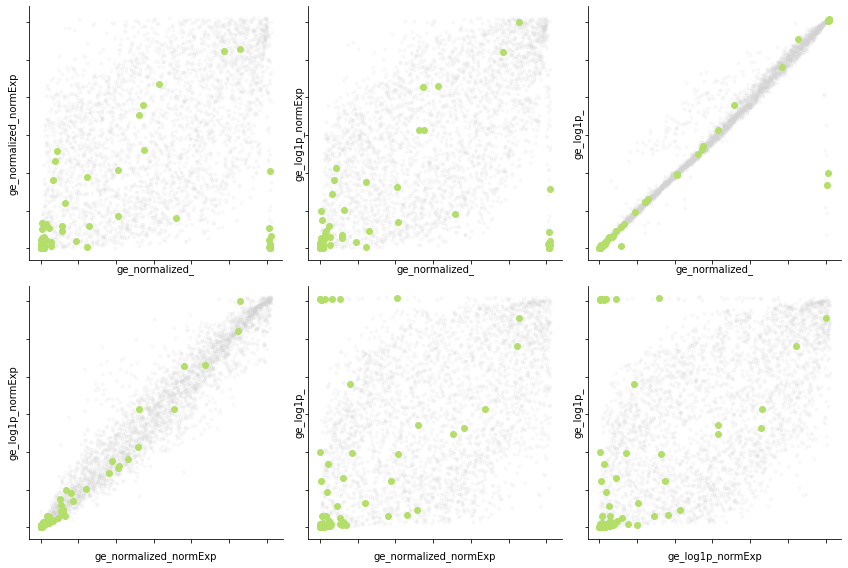

In [6]:
# Read data
files = os.listdir('../expression_csv/')
ge_files = [_file for _file in files if _file.startswith('ge_')]
ge_table_list = {}

cloned_genes = pd.read_csv('../output/cloned_genes.csv')['0'].to_list()
# cloned_genes = [i for i in cloned_genes if 'Syt' not in i ]

# Read and melt the gene expression data matrix 
for _file in ge_files: 
    ge_table_list['_'.join(_file.split('GSE')[0].split('_')[0:3])] = pd.read_csv(os.path.join('../expression_csv', _file), index_col = 0)

# Filters the data by meaningful counts. Genes with only low counts at one time point is excluded. (ex. 0,0,0,0,0,0.4)
subset_genes = ge_table_list['ge_normalized_normExp'].set_index('index').sum()[ge_table_list['ge_normalized_normExp'].set_index('index').sum().sort_values() > 1].index
subset_genes = random.sample(list(subset_genes), 3000)
subset_genes.extend(i for i in (cloned_genes + ['Rtp1']) if i not in subset_genes)

mse_table_list = {}
for _key in ge_table_list.keys(): 
    mse_table_list[_key] = GE_functions.get_rmse_table(ge_table_list[_key].set_index('index')[subset_genes], 'Rtp1')


fig, axes = plt.subplots(2, 3, 
                         figsize=(12, 8), 
                         sharex=True, sharey=True)

for ax, _compare in zip_longest(axes.flatten(), list(combinations(ge_table_list.keys(), 2))):
    if _compare is not None: 
        x_by, y_by = _compare
        base_plots_x = mse_table_list[x_by].rank()[~mse_table_list[x_by].index.isin(cloned_genes)]
        base_plots_y = mse_table_list[y_by].rank()[~mse_table_list[y_by].index.isin(cloned_genes)]
        ax.scatter(base_plots_x, 
                   base_plots_y, 
                   marker='.', 
                   c = '#d3d3d3',
                   alpha=0.1)
        
        # Cloned genes
        plots_x = mse_table_list[x_by].rank()[cloned_genes]
        plots_y = mse_table_list[y_by].rank()[cloned_genes]
        ax.scatter(plots_x, 
                   plots_y, 
                #    c = '#ff5959', 
                   c = '#b3de69',
                   alpha=1)

        ax.set_xlabel(x_by)  # Set x label for this subplot
        ax.set_ylabel(y_by)  # Set y label for this subplot
        ax.spines['top'].set_visible(False)  # Turn off top spine for this subplot
        ax.spines['right'].set_visible(False)  # Turn off right spine for this subplot
        # ax.set_xlim(0,100)
        # ax.set_ylim(0,100)
        ax.set_xticklabels([])  # Remove x tick labels and numbers
        ax.set_yticklabels([])  # Remove y tick labels and numbers
        ax.set_box_aspect(1)  # Set aspect ratio to be a square for this subplot
    else: 
        ax.axis("off")

plt.subplots_adjust(wspace=0, hspace=0.1)
# Show plot
fig.tight_layout()
# plt.savefig('../output/fig_image/metric_rank_corr_Rtp1.png')
plt.show()

##### Syt family rank metric 

In [65]:
df = pd.DataFrame()
for _k in ge_table_list.keys():
    temp = GE_functions.get_rmse_table(ge_table_list[_k].set_index('index'))
    df = pd.merge(df, pd.DataFrame(temp, columns=[_k]), how='outer', left_index=True, right_index=True)
exclude_0_genes = ge_table_list['ge_normalized_normExp'].set_index('index').sum()[ge_table_list['ge_normalized_normExp'].set_index('index').sum().sort_values() > 1].index
df = df[df.index.isin(exclude_0_genes)]
df = df.rank()

# Quick dataframe to show rank of Syt across metrics. 
df[df.index.str.startswith('Syt')]

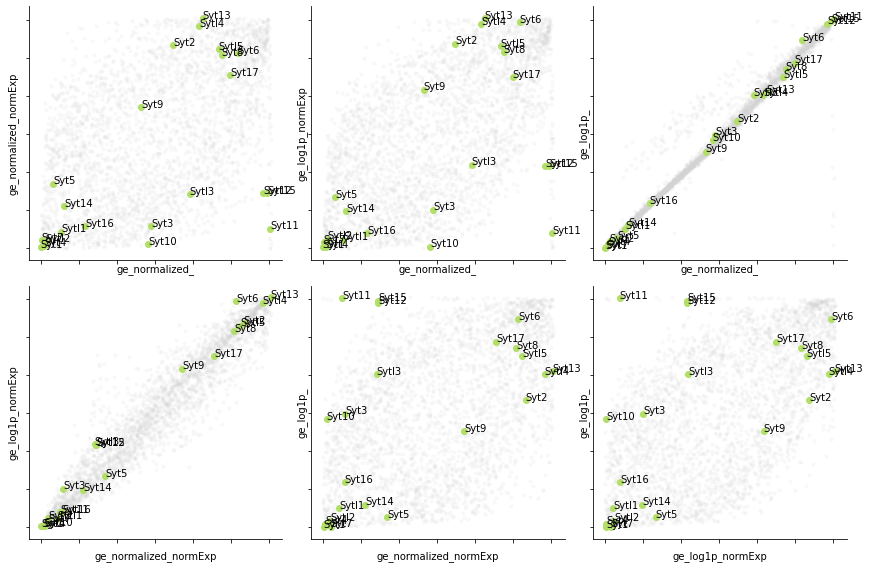

In [24]:
# Read data
files = os.listdir('../expression_csv/')
ge_files = [_file for _file in files if _file.startswith('ge_')]
ge_table_list = {}

# cloned_genes = pd.read_csv('../output/cloned_genes.csv')['0'].to_list()

# Read and melt the gene expression data matrix 
for _file in ge_files: 
    ge_table_list['_'.join(_file.split('GSE')[0].split('_')[0:3])] = pd.read_csv(os.path.join('../expression_csv', _file), index_col = 0)

cloned_genes = [_gene for _gene in ge_table_list[list(ge_table_list.keys())[0]].columns if _gene.startswith('Syt')]


# Filters the data by meaningful counts. Genes with only low counts at one time point is excluded. (ex. 0,0,0,0,0,0.4)
subset_genes = ge_table_list['ge_normalized_normExp'].set_index('index').sum()[ge_table_list['ge_normalized_normExp'].set_index('index').sum().sort_values() > 1].index
subset_genes = random.sample(list(subset_genes), 3000)
subset_genes.extend(i for i in (cloned_genes + ['Rtp1']) if i not in subset_genes)

mse_table_list = {}
for _key in ge_table_list.keys(): 
    mse_table_list[_key] = GE_functions.get_rmse_table(ge_table_list[_key].set_index('index')[subset_genes], 'Rtp1')


fig, axes = plt.subplots(2, 3, 
                         figsize=(12, 8), 
                         sharex=True, sharey=True)

for ax, _compare in zip_longest(axes.flatten(), list(combinations(ge_table_list.keys(), 2))):
    if _compare is not None: 
        x_by, y_by = _compare
        base_plots_x = mse_table_list[x_by].rank()[~mse_table_list[x_by].index.isin(cloned_genes)]
        base_plots_y = mse_table_list[y_by].rank()[~mse_table_list[y_by].index.isin(cloned_genes)]
        ax.scatter(base_plots_x, 
                   base_plots_y, 
                   marker='.', 
                   c = '#d3d3d3',
                   alpha=0.1)
        
        # Cloned genes
        plots_x = mse_table_list[x_by].rank()[cloned_genes]
        plots_y = mse_table_list[y_by].rank()[cloned_genes]
        ax.scatter(plots_x, 
                   plots_y, 
                #    c = '#ff5959', 
                   c = '#b3de69',
                   alpha=1)

        ax.set_xlabel(x_by)  # Set x label for this subplot
        ax.set_ylabel(y_by)  # Set y label for this subplot
        ax.spines['top'].set_visible(False)  # Turn off top spine for this subplot
        ax.spines['right'].set_visible(False)  # Turn off right spine for this subplot
        # ax.set_xlim(0,100)
        # ax.set_ylim(0,100)
        ax.set_xticklabels([])  # Remove x tick labels and numbers
        ax.set_yticklabels([])  # Remove y tick labels and numbers
        ax.set_box_aspect(1)  # Set aspect ratio to be a square for this subplot
        
        for i in range(len(plots_x)):
            ax.annotate(plots_x.index[i], (plots_x[i], plots_y[i]))
    else: 
        ax.axis("off")

plt.subplots_adjust(wspace=0, hspace=0.1)
# Show plot
fig.tight_layout()
# plt.savefig('../output/fig_image/metric_rank_corr_Rtp1.png')
plt.show()

### top cloned genes on curve

In [2]:
import pandas as pd 
import plotly.graph_objects as go

import utils.GE_functions as GE_functions

In [36]:
reversed(ge_data['gene'].unique())

In [47]:
ge_normalized = pd.read_csv('../expression_csv/ge_normalized_normExp_GSE151346_MOE_ALL_OlfrSum.csv', 
                            index_col=0)


# cloned_genes = pd.read_csv('../output/cloned_genes.csv')['0'].to_list()
cloned_genes = list(GE_functions.get_rmse_table(ge_normalized.set_index('index'), 'Rtp1').sort_values().index)

plot_genes = []
plot_genes.extend(cloned_genes[0:10])
plot_genes.extend(cloned_genes[10:1000][0::10])

color_map = GE_functions.continuous_colors(GE_functions.get_rmse_table(ge_normalized[plot_genes], 'Rtp1').sort_values().index, colormap = 'viridis_r')

fig = go.Figure()

ge_data = GE_functions.get_ge_data(ge_normalized, plot_genes)
for g in reversed(ge_data['gene'].unique()):
    plot_data = ge_data[ge_data['gene'] == g]    
    fig.add_trace(go.Scatter(x= plot_data['index'], 
                             y= plot_data['expression'],
                             opacity = 0.8,
                             mode ='lines', 
                             line_shape='spline',
                             name = g,
                             line=dict(
                                color = color_map[g],
                                width=8
#                                 dash = 'dot'
                            )
                        ))

# Add bolded lines for specific genes 
ge_data = GE_functions.get_ge_data(ge_normalized, ['Rtp1'])
for g in ge_data['gene'].unique():
    plot_data = ge_data[ge_data['gene'] == g]
    fig.add_trace(go.Scatter(x= plot_data['index'], 
                             y= plot_data['expression'],
                             mode = 'lines',
                             line_shape='spline',
                             name = g, 
                             line=dict(
                                color='black',
                                 dash='dot',
                                width=8)
    ))
    
fig.update_layout(xaxis_type = 'category',template='simple_white', # update x-axis to category so that it doesn't sort the numbers
                 title='top genes associated with Rtp1<br>\
    <span style="font-size: 10px;">Data from Brann et al. scRNAseq WOM</span>',
                 font=dict(
        size=20,
    ))
fig.show()

fig.write_html("../output/fig_image/mOSN_analysis/geLine_Rtp1_associated_genes.html")


ge_data constructed
ge_data constructed


In [12]:
ge_normalized

,index,0610005C13Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012G03Rik,0610025J13Rik,...,Olfr964-ps1,Spink12,Tas2r123,Vmn1r189,Vmn2r26,Olfr_sum,uOR_sum,oOR_sum,oOR_null_sum,dpt_average
0,0-0.3,0.241148,0.888313,0.852401,0.052272,1.000000,0.315639,0.679866,0.552380,0.240110,...,0.0,0.0,0.0,0.0,0.0,0.025310,0.022362,0.032723,0.022929,0.138062
1,0.3-0.6,1.000000,0.928057,0.647200,0.382170,0.596231,0.583612,1.000000,0.894207,0.057510,...,0.0,0.0,0.0,0.0,0.0,0.035956,0.031318,0.036327,0.044848,0.497584
2,0.6-0.7,0.000000,0.932412,0.470525,1.000000,0.345592,0.521785,0.539109,1.000000,0.819655,...,0.0,0.0,0.0,0.0,0.0,0.153170,0.132559,0.123488,0.128564,0.648816
3,0.7-0.8,0.000000,1.000000,0.569768,0.516902,0.609177,1.000000,0.630650,0.984075,1.000000,...,1.0,0.0,1.0,0.0,0.0,0.497234,0.446889,0.427860,0.435668,0.747447
4,0.8-0.9,0.000000,0.604839,1.000000,0.280287,0.749391,0.798242,0.568962,0.720484,0.749846,...,0.0,0.0,0.0,0.0,0.0,0.765842,0.734809,0.660935,0.809379,0.848554
5,0.9-0.95,0.000000,0.719084,0.565242,0.304972,0.717314,0.490117,0.000000,0.537646,0.311477,...,0.0,1.0,0.0,0.0,0.0,0.881694,0.977037,0.441503,0.450901,0.931854
6,0.95-1,0.009004,0.768121,0.589587,0.120605,0.944471,0.249516,0.435751,0.792862,0.090339,...,0.0,0.0,0.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,0.977241


In [24]:
ge_normalized = pd.read_csv('../expression_csv/ge_normalized_normExp_GSE151346_MOE_ALL_OlfrSum.csv', 
                            index_col=0)

plot_genes = ['Hmgb2', 'Tubb5', 'Gap43','Omp', 'Olfr_sum']
# plot_genes = ['Sox11', 'Tubb5', 'Gap43','Omp', 'Olfr_sum']



color_map = GE_functions.distinct_colors(GE_functions.get_rmse_table(ge_normalized[plot_genes + ['Rtp1']], 'Rtp1', 
                                                                     no_filter=True).sort_values().index, 
                                         category='pastel')

fig = go.Figure()

ge_data = GE_functions.get_ge_data(ge_normalized, plot_genes)
for g in reversed(ge_data['gene'].unique()):
    plot_data = ge_data[ge_data['gene'] == g]    
    fig.add_trace(go.Scatter(x= plot_data['index'], 
                             y= plot_data['expression'],
                             opacity = 0.8,
                             mode ='lines', 
                             line_shape='spline',
                             name = g,
                             line=dict(
                                color = color_map[g],
                                width=8
#                                 dash = 'dot'
                            )
                        ))

# Add bolded lines for specific genes 
ge_data = GE_functions.get_ge_data(ge_normalized, ['Rtp1'])
for g in ge_data['gene'].unique():
    plot_data = ge_data[ge_data['gene'] == g]
    fig.add_trace(go.Scatter(x= plot_data['index'], 
                             y= plot_data['expression'],
                             mode = 'lines',
                             line_shape='spline',
                             name = g, 
                             line=dict(
                                color='black',
                                 dash='dot',
                                width=8)
    ))
    
fig.update_layout(xaxis_type = 'category',template='simple_white', # update x-axis to category so that it doesn't sort the numbers
                 title='top genes associated with Rtp1<br>\
    <span style="font-size: 10px;">Data from Brann et al. scRNAseq WOM</span>',
                 font=dict(
        size=20,
    ))
fig.show()

# fig.write_html("../output/fig_image/mOSN_analysis/geLine_demo_plot.html")


ge_data constructed
ge_data constructed


#### Gene function of cloned genes 

In [ ]:
cloned_genes = pd.read_csv('../output/cloned_genes.csv')['0'].to_list()
